In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Intalación de las dependencias necesarias
!apt-get -qq install xxd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

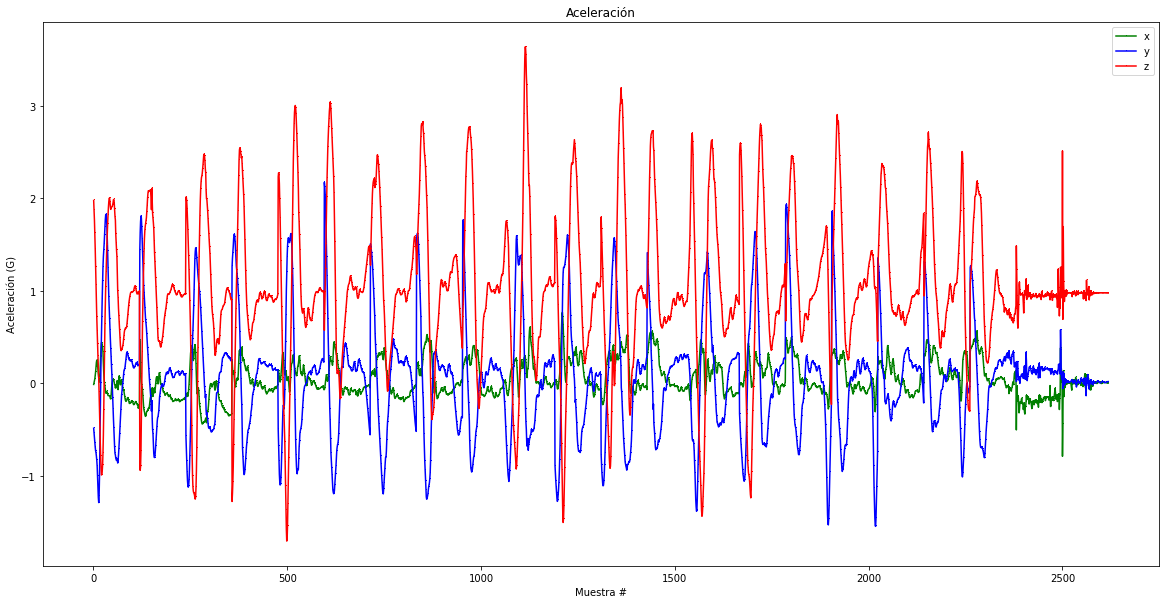

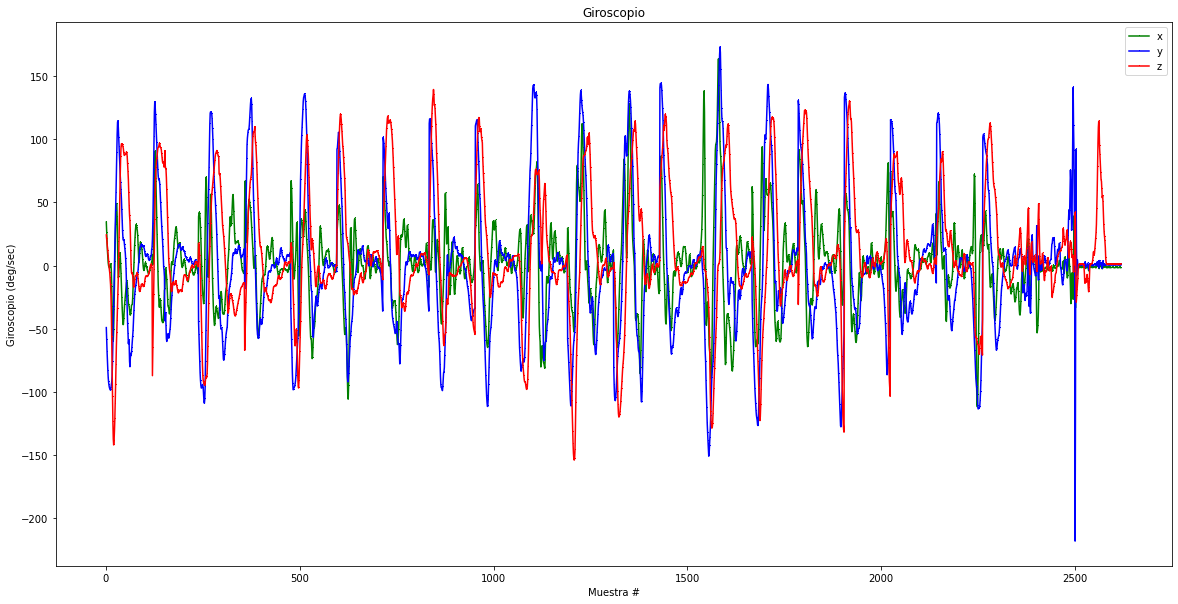

In [ ]:

filename = "/content/gdrive/MyDrive/Colab Notebooks/Movimiento/hombro.csv"

df = pd.read_csv(filename)


index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Aceleración")
plt.xlabel("Muestra #")
plt.ylabel("Aceleración (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Giroscopio")
plt.xlabel("Muestra #")
plt.ylabel("Giroscopio (deg/sec)")
plt.legend()
plt.show()


In [ ]:

#print(f"TensorFlow version = {tf.__version__}\n")
# Establezca un valor semilla aleatorio fijo, para la reproducibilidad, esto nos permitirá obtener
# los mismos números aleatorios cada vez que se ejecuta el cuaderno
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# la lista de gestos para los que hay datos disponibles
GESTURES = [
    "brazo_alfrente",
    "flexion",
    "hombro",
    "levantamiento",
    "tronco",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# crear una matriz codificada one-hot que se utiliza en la salida
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# leer cada archivo csv y enviar una entrada y una salida
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Procesando índice {gesture_index} para gesto '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Movimiento/" + gesture + ".csv")
  
# calcular el número de grabaciones de gestos en el archivo
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tHay {num_recordings} grabaciones del gesto {gesture}.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalizar los datos de entrada, entre 0 y 1:
      # - la aceleración está entre: -4 a +4
      # - el giroscopio está entre: -2000 a +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convertir la lista en una matriz numpy
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Se completó el análisis y la preparación del conjunto de datos.")

Procesando índice 0 para gesto 'brazo_alfrente'.
	Hay 20 grabaciones del gesto brazo_alfrente.
Procesando índice 1 para gesto 'flexion'.
	Hay 20 grabaciones del gesto flexion.
Procesando índice 2 para gesto 'hombro'.
	Hay 22 grabaciones del gesto hombro.
Procesando índice 3 para gesto 'levantamiento'.
	Hay 20 grabaciones del gesto levantamiento.
Procesando índice 4 para gesto 'tronco'.
	Hay 18 grabaciones del gesto tronco.
Se completó el análisis y la preparación del conjunto de datos.


In [ ]:
# Aleatorice el orden de las entradas, de modo que puedan distribuirse uniformemente para el entrenamiento, la prueba y la validación
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Intercambiar los índices consecutivos (0, 1, 2, etc.) con los índices aleatorios
inputs = inputs[randomize]
outputs = outputs[randomize]

# Divida las grabaciones (grupo de muestras) en tres conjuntos: entrenamiento, prueba y validación
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Se completó la aleatorización y división del conjunto de datos.")

Se completó la aleatorización y división del conjunto de datos.


In [ ]:
# Definición y entrenamiento del modelo
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) 
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) 
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
60/60 [==============================] - 1s 6ms/step - loss: 0.1650 - mae: 0.3227 - val_loss: 0.1646 - val_mae: 0.3240
Epoch 2/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1606 - mae: 0.3195 - val_loss: 0.1635 - val_mae: 0.3230
Epoch 3/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1596 - mae: 0.3172 - val_loss: 0.1688 - val_mae: 0.3264
Epoch 4/600
60/60 [==============================] - 0s 4ms/step - loss: 0.1582 - mae: 0.3157 - val_loss: 0.1694 - val_mae: 0.3272
Epoch 5/600
60/60 [==============================] - 0s 4ms/step - loss: 0.1560 - mae: 0.3124 - val_loss: 0.1662 - val_mae: 0.3248
Epoch 6/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1549 - mae: 0.3114 - val_loss: 0.1719 - val_mae: 0.3281
Epoch 7/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1539 - mae: 0.3104 - val_loss: 0.1673 - val_mae: 0.3244
Epoch 8/600
60/60 [==============================] - 0s 3ms/step - loss: 0.1521 - m

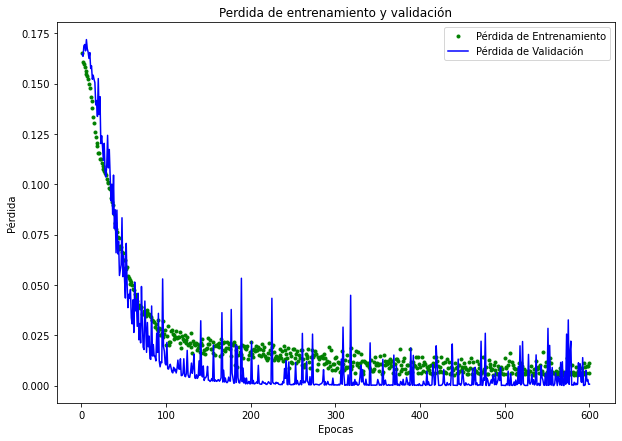

[10.0, 7.0]


In [ ]:
# aumentar el tamaño de los gráficos. El tamaño predeterminado es (6,4).
plt.rcParams["figure.figsize"] = (10,7)

# graficar la pérdida, el modelo anterior está configurado para usar "error cuadrático medio" como la función de pérdida
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de Validación')
plt.title('Perdida de entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [ ]:
# usar el modelo para predecir las entradas de prueba
predictions = model.predict(inputs_test)

# imprime las predicciones y los resultados esperados
print("predicciones =\n", np.round(predictions, decimals=3))
print("reales =\n", outputs_test)



1/1 [==============================] - 0s 71ms/step
predicciones =
 [[0.001 0.998 0.    0.    0.002]
 [0.    0.    1.    0.    0.   ]
 [0.995 0.    0.005 0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.963 0.    0.037 0.    0.   ]
 [0.008 0.    0.    0.    0.992]
 [0.    0.    1.    0.    0.   ]
 [0.01  0.    0.    0.    0.99 ]
 [0.    0.    0.    1.    0.   ]
 [0.04  0.    0.    0.    0.96 ]
 [0.017 0.    0.    0.    0.983]
 [0.912 0.    0.088 0.    0.   ]
 [0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.017 0.    0.983 0.    0.   ]
 [0.005 0.    0.995 0.    0.   ]
 [0.    0.    0.    1.    0.   ]
 [0.    0.    0.    1.    0.   ]]
reales =
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         3
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.95        20
   macro avg       0.97      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

[[3 0 1 0 0]
 [0 3 0 0 0]
 [0 0 5 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]


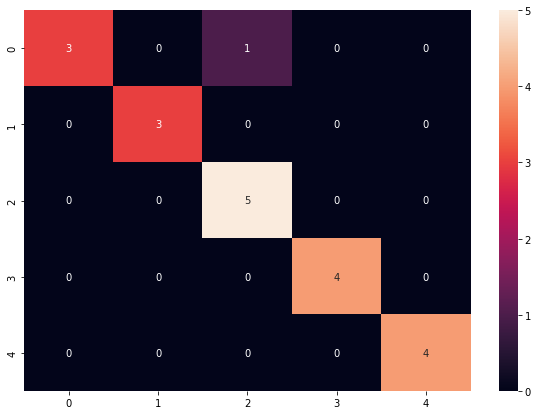

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_class = np.argmax(outputs_test,axis=1) 
y_pred_class = np.argmax(predictions,axis=1) 

#Exactitud de los valores predichos
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)

# visualizar la matriz de confusión en un mapa de calor
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [ ]:
# Convierta el modelo al formato TensorFlow Lite sin cuantificación
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


# Guardar el modelo en el disco
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 148448 bytes


In [ ]:
#La siguiente celda crea una matriz de bytes constantes que contiene el modelo TFlite. 
#Importarlo como una pestaña con el siguiente código.

!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nAbre el panel lateral (refrecar si es necesario). Doble click en model.h para descargar el archivo.")

Header file, model.h, is 915,464 bytes.

Abre el panel lateral (refrecar si es necesario). Doble click en model.h para descargar el archivo.
